In [1]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2

In [3]:
len(os.listdir('data/test_img')) # 1000

127

In [4]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop

In [5]:
Thickness.reset_index(drop=True, inplace=True)
Thickness

,Thickness
0,48.266667
1,47.966667
2,48.166667
3,48.600000
4,59.533333
...,...
122,84.633333
123,98.366667
124,97.033333
125,96.266667


In [6]:
img_path_list = []

for i in range(1, 33):
    for j in range(1, 5):
        if i == 9 and j == 1: 
            continue
        img_path_list.append('./data/test_img/AI-{}_0{}_transformed.jpg'.format(i, j))
        
img_path_list[:5]


['./data/test_img/AI-1_01_transformed.jpg',
 './data/test_img/AI-1_02_transformed.jpg',
 './data/test_img/AI-1_03_transformed.jpg',
 './data/test_img/AI-1_04_transformed.jpg',
 './data/test_img/AI-2_01_transformed.jpg']

In [7]:
class dataset(Dataset):
    def __init__(self, img_path, thickness, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.thickness = thickness
        
    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path[idx])
        img = np.array(img)
        if self.transform:
            img = self.transform(img)
        y = self.thickness[idx]
        return img, y

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

In [9]:
seed = 20
train, test = train_test_split(img_path_list, test_size=0.2, random_state=seed)

train_dataset = dataset(train, Thickness['Thickness'], transform)
test_dataset = dataset(test, Thickness['Thickness'], transform)

In [10]:
print(len(train_dataset), len(test_dataset))

101 26


In [11]:
efficientnet = torch.hub.load('rwightman/gen-efficientnet-pytorch', 'efficientnet_b0', pretrained=True)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.efficientnet = efficientnet
        self.fc1 = nn.Linear(1000, 1)
        
        for param in self.efficientnet.parameters():
            if param.dim() == 4:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
    def forward(self, x):
        x = self.efficientnet(x)
        x = self.fc1(x)
        return x
    
model = Net()


Using cache found in C:\Users\se99a/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

Net(
  (efficientnet): GenEfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [13]:
def train(model, train_loader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.float().to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return model
            
def test(model, test_loader):
    model.eval()
    test_loss = 0
    output_list  = []
    thickness_list = []
    with torch.no_grad():
        for data, target in test_loader:
            thickness_list.append(target)
            data = data.to(device)
            target = target.float().to(device)
            output = model(data)
            test_loss += criterion(output, target.unsqueeze(1)).item()
            output_list.append(output)
    test_loss /= len(test_loader.dataset)
    return test_loss, output_list, thickness_list


In [14]:
epochs = 30
model = train(model, train_loader, optimizer, epochs)

c:\Users\se99a\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Epoch: 0 [0/101 (0%)]	Loss: 8161.880859
Train Epoch: 1 [0/101 (0%)]	Loss: 7597.273438
Train Epoch: 2 [0/101 (0%)]	Loss: 5886.404785
Train Epoch: 3 [0/101 (0%)]	Loss: 4960.869629
Train Epoch: 4 [0/101 (0%)]	Loss: 3582.668457
Train Epoch: 5 [0/101 (0%)]	Loss: 3101.839844
Train Epoch: 6 [0/101 (0%)]	Loss: 2177.316650
Train Epoch: 7 [0/101 (0%)]	Loss: 1936.450073
Train Epoch: 8 [0/101 (0%)]	Loss: 1669.771606
Train Epoch: 9 [0/101 (0%)]	Loss: 1345.402466
Train Epoch: 10 [0/101 (0%)]	Loss: 1044.764526
Train Epoch: 11 [0/101 (0%)]	Loss: 861.414734
Train Epoch: 12 [0/101 (0%)]	Loss: 740.139954
Train Epoch: 13 [0/101 (0%)]	Loss: 559.399780
Train Epoch: 14 [0/101 (0%)]	Loss: 417.018463
Train Epoch: 15 [0/101 (0%)]	Loss: 236.046631
Train Epoch: 16 [0/101 (0%)]	Loss: 63.016907
Train Epoch: 17 [0/101 (0%)]	Loss: 21.532911
Train Epoch: 18 [0/101 (0%)]	Loss: 17.917542
Train Epoch: 19 [0/101 (0%)]	Loss: 41.103542
Train Epoch: 20 [0/101 (0%)]	Loss: 22.413170
Train Epoch: 21 [0/101 (0%)]	Loss: 34.

In [15]:
test_loss, output_list, thickness_list = test(model, test_loader)

In [16]:
test_loss

16.93749765249399

In [17]:
output = np.array(output_list[0])
thickness = np.array(thickness_list[0])

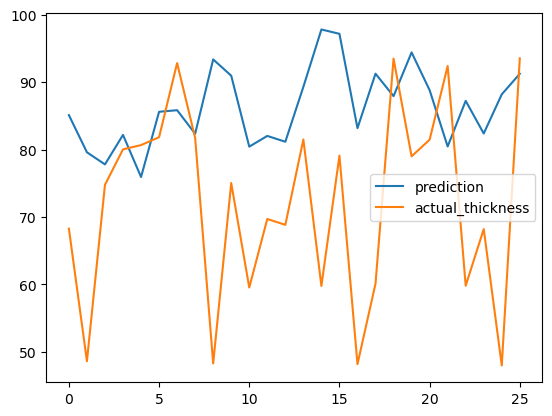

In [23]:
plt.plot(output)
plt.plot(thickness)
plt.legend(['prediction', 'actual_thickness'])
plt.show()

In [19]:
pd.DataFrame({'prediction': output.reshape(-1), 'thickness': thickness.reshape(-1)})

,prediction,thickness
0,85.115059,68.266667
1,79.599388,48.600000
2,77.800461,74.766667
3,82.177628,80.033333
4,75.928391,80.666667
5,85.607941,81.833333
6,85.843010,92.833333
7,82.354401,81.733333
8,93.380104,48.266667
9,90.961746,75.033333
